# Beta-VAE探索

## Mnist数据上的探索

In [1]:
import os
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow.contrib import layers
from matplotlib import pyplot as plt

/Users/zhouwj/miniconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(70000, 784) (70000,)


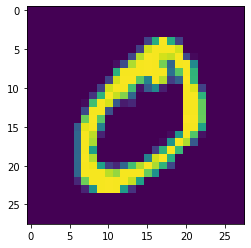

In [2]:
with open('data/mnist.pkl','rb') as f:
    ft, lbl = pkl.load(f)
print(ft.shape, lbl.shape)

#ft = ft*2 -1
plt.imshow(np.reshape(ft[1], [28,28]))

In [3]:
print(np.min(ft), np.max(ft))

0.0 0.99609375


In [4]:
train_ft = ft[:50000,:]
train_lbl = lbl[:50000]

test_ft = ft[50000:,:]
test_lbl = lbl[50000:]

### 模型构建

In [5]:
class BetaVAE:
    def __init__(self, name='bvae', z_dim=10, x_dim=784, beta=0.02, lr=2e-4):
        self.name = name
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.beta = beta
        self.lr = lr
        self.is_training = True
        self.save_path = os.path.join('logs', self.name)
        self.global_step = 0
        
        self._build()
        
        self.saver = tf.train.Saver(max_to_keep=1)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self._summary()
        
    def _build(self): 
        def _Enc(inp, dim=512):
            with tf.variable_scope('Enc', reuse=tf.AUTO_REUSE):
                y = layers.fully_connected(inp, dim, activation_fn=tf.nn.relu)
                y = layers.fully_connected(y, dim * 2, activation_fn=tf.nn.relu)
                z_mu = layers.fully_connected(y, self.z_dim, activation_fn=None)
                z_log_sigma_sq = layers.fully_connected(y, self.z_dim, activation_fn=None)
                return z_mu, z_log_sigma_sq

        def _Dec(z, dim=512):
            with tf.variable_scope('Dec', reuse=tf.AUTO_REUSE):
                y = layers.fully_connected(z, dim * 2, activation_fn=tf.nn.relu)
                y = layers.fully_connected(y, dim, activation_fn=tf.nn.relu)
                y = layers.fully_connected(y, self.x_dim, activation_fn=tf.nn.sigmoid)
                return y
        
        with tf.variable_scope(self.name):
            self.x_ph = tf.placeholder(tf.float32, [None, self.x_dim], name='x_ph')
            self.z_ph = tf.placeholder(tf.float32, [None, self.z_dim], name='z_ph')

            z_mu, z_log_sigma_sq = _Enc(self.x_ph)
            # sample
            epsilon = tf.random_normal(tf.shape(z_mu))
            z = z_mu + tf.exp(0.5 * z_log_sigma_sq) * epsilon
            self.z_t = z_mu

            # decode
            self.x_rec = _Dec(z)
            self.predict_x = _Dec(self.z_t)
            self.predict_zx = _Dec(self.z_ph)
             
            with tf.variable_scope('Loss'):
                self.rec_loss = tf.losses.mean_squared_error(self.x_ph, self.x_rec)
                self.kld_loss = -tf.reduce_mean(0.5 * (1 + z_log_sigma_sq - z_mu**2 - tf.exp(z_log_sigma_sq)))
                self.loss = self.rec_loss + self.kld_loss * self.beta
            with tf.variable_scope('Opt'):
                self.train_op = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5).minimize(self.loss)
                
            # identity
            self.z_mu = z_mu
            self.z_log_sigma_sq = z_log_sigma_sq
                
    def _summary(self):
        with tf.name_scope('Summary'):
            tf.summary.scalar(name='loss', tensor=self.loss)
            tf.summary.scalar(name='rec_loss', tensor=self.rec_loss)
            tf.summary.scalar(name='kld_loss', tensor=self.kld_loss)
            tf.summary.scalar(name='z_mu_mean', tensor=tf.reduce_mean(self.z_mu))
            tf.summary.scalar(name='z_sigma_mean', tensor=tf.reduce_mean(self.z_log_sigma_sq))
            
            self.sum_ops = tf.summary.merge_all()
        
        self.writer_1 = tf.summary.FileWriter(self.save_path, self.sess.graph)
    
    def save(self):
        self.saver.save(self.sess, os.path.join(self.save_path, 'model'))
        
    def load(self):
        self.saver.restore(self.sess, os.path.join(self.save_path, 'model'))
        
    def close_sess(self):
        self.sess.close()
        
    def train(self, n_epoch, data, batch_size=64):
        N = data.shape[0]
        for ep in range(n_epoch):
            itr = 0
            shuffled_data = data.copy()
            np.random.shuffle(shuffled_data)
            while True:
                if itr * batch_size > N:
                    break
                ft = shuffled_data[itr * batch_size : (itr+1) * batch_size, :]
                _,sum_all,loss, rec, kld = self.sess.run([self.train_op, self.sum_ops, self.loss, self.rec_loss, self.kld_loss], feed_dict={self.x_ph: ft})
                
                if itr%100==0:
                    print('ep:{}\titr:{}\tloss:{:.6f}\trec_loss:{:.6f}\tkld_loss:{:.6f}'.format(ep, itr, loss,rec, kld))
                    self.writer_1.add_summary(sum_all, global_step=self.global_step)  
                
                itr += 1
                self.global_step += 1
    
    def predict(self, x):
        x_rec = self.sess.run(self.predict_x, feed_dict={self.x_ph:x})
        return x_rec
    
    def predict_z(self, z):
        x_rec = self.sess.run(self.predict_zx, feed_dict={self.z_ph:z})
        return x_rec

In [6]:
model = BetaVAE()
model.train(n_epoch=50, data=train_ft)

ep:0	itr:0	loss:0.233054	rec_loss:0.232412	kld_loss:0.032102
ep:0	itr:100	loss:0.068880	rec_loss:0.067888	kld_loss:0.049621
ep:0	itr:200	loss:0.068415	rec_loss:0.066877	kld_loss:0.076905
ep:0	itr:300	loss:0.067048	rec_loss:0.064362	kld_loss:0.134305
ep:0	itr:400	loss:0.066437	rec_loss:0.063296	kld_loss:0.157089
ep:0	itr:500	loss:0.057314	rec_loss:0.052597	kld_loss:0.235860
ep:0	itr:600	loss:0.059951	rec_loss:0.053999	kld_loss:0.297608
ep:0	itr:700	loss:0.053574	rec_loss:0.045678	kld_loss:0.394833
ep:1	itr:0	loss:0.053090	rec_loss:0.045603	kld_loss:0.374355
ep:1	itr:100	loss:0.056113	rec_loss:0.047181	kld_loss:0.446617
ep:1	itr:200	loss:0.055889	rec_loss:0.046806	kld_loss:0.454123
ep:1	itr:300	loss:0.053079	rec_loss:0.043349	kld_loss:0.486504
ep:1	itr:400	loss:0.050481	rec_loss:0.041233	kld_loss:0.462381
ep:1	itr:500	loss:0.050997	rec_loss:0.041377	kld_loss:0.481017
ep:1	itr:600	loss:0.052135	rec_loss:0.042102	kld_loss:0.501653
ep:1	itr:700	loss:0.052484	rec_loss:0.041211	kld_loss:0.563

ep:16	itr:200	loss:0.044935	rec_loss:0.029130	kld_loss:0.790249
ep:16	itr:300	loss:0.042972	rec_loss:0.027825	kld_loss:0.757338
ep:16	itr:400	loss:0.042792	rec_loss:0.027322	kld_loss:0.773490
ep:16	itr:500	loss:0.046187	rec_loss:0.029762	kld_loss:0.821246
ep:16	itr:600	loss:0.043968	rec_loss:0.027930	kld_loss:0.801935
ep:16	itr:700	loss:0.043156	rec_loss:0.027456	kld_loss:0.785036
ep:17	itr:0	loss:0.043464	rec_loss:0.027846	kld_loss:0.780906
ep:17	itr:100	loss:0.043660	rec_loss:0.027718	kld_loss:0.797099
ep:17	itr:200	loss:0.043080	rec_loss:0.027181	kld_loss:0.794952
ep:17	itr:300	loss:0.042603	rec_loss:0.027036	kld_loss:0.778399
ep:17	itr:400	loss:0.040694	rec_loss:0.025905	kld_loss:0.739428
ep:17	itr:500	loss:0.045023	rec_loss:0.029292	kld_loss:0.786518
ep:17	itr:600	loss:0.042042	rec_loss:0.026858	kld_loss:0.759242
ep:17	itr:700	loss:0.043014	rec_loss:0.027566	kld_loss:0.772430
ep:18	itr:0	loss:0.041445	rec_loss:0.026717	kld_loss:0.736436
ep:18	itr:100	loss:0.045022	rec_loss:0.02949

ep:32	itr:300	loss:0.041113	rec_loss:0.024851	kld_loss:0.813113
ep:32	itr:400	loss:0.043015	rec_loss:0.025917	kld_loss:0.854912
ep:32	itr:500	loss:0.041102	rec_loss:0.025636	kld_loss:0.773328
ep:32	itr:600	loss:0.040778	rec_loss:0.023714	kld_loss:0.853171
ep:32	itr:700	loss:0.043256	rec_loss:0.026076	kld_loss:0.858999
ep:33	itr:0	loss:0.042118	rec_loss:0.026018	kld_loss:0.805012
ep:33	itr:100	loss:0.041786	rec_loss:0.024724	kld_loss:0.853132
ep:33	itr:200	loss:0.041126	rec_loss:0.025442	kld_loss:0.784164
ep:33	itr:300	loss:0.041545	rec_loss:0.025494	kld_loss:0.802512
ep:33	itr:400	loss:0.041746	rec_loss:0.025817	kld_loss:0.796485
ep:33	itr:500	loss:0.044360	rec_loss:0.027013	kld_loss:0.867349
ep:33	itr:600	loss:0.039115	rec_loss:0.022866	kld_loss:0.812422
ep:33	itr:700	loss:0.044899	rec_loss:0.027803	kld_loss:0.854833
ep:34	itr:0	loss:0.040778	rec_loss:0.024125	kld_loss:0.832632
ep:34	itr:100	loss:0.041723	rec_loss:0.025436	kld_loss:0.814377
ep:34	itr:200	loss:0.040993	rec_loss:0.02450

ep:48	itr:400	loss:0.041699	rec_loss:0.025409	kld_loss:0.814495
ep:48	itr:500	loss:0.044504	rec_loss:0.027333	kld_loss:0.858558
ep:48	itr:600	loss:0.043392	rec_loss:0.025890	kld_loss:0.875107
ep:48	itr:700	loss:0.039482	rec_loss:0.022860	kld_loss:0.831101
ep:49	itr:0	loss:0.040113	rec_loss:0.023318	kld_loss:0.839709
ep:49	itr:100	loss:0.043019	rec_loss:0.025240	kld_loss:0.888939
ep:49	itr:200	loss:0.040255	rec_loss:0.023973	kld_loss:0.814113
ep:49	itr:300	loss:0.042608	rec_loss:0.025090	kld_loss:0.875901
ep:49	itr:400	loss:0.039969	rec_loss:0.022940	kld_loss:0.851462
ep:49	itr:500	loss:0.041241	rec_loss:0.024212	kld_loss:0.851460
ep:49	itr:600	loss:0.041846	rec_loss:0.023785	kld_loss:0.903088
ep:49	itr:700	loss:0.040958	rec_loss:0.024273	kld_loss:0.834218


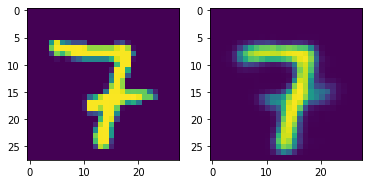

In [7]:
x = test_ft[100,:]
x_rec = model.predict(np.reshape(x,[1,-1]))

plt.subplot(1,2,1)
plt.imshow(np.reshape(x,[28,28]))
plt.subplot(1,2,2)
plt.imshow(np.reshape(x_rec,[28,28]))


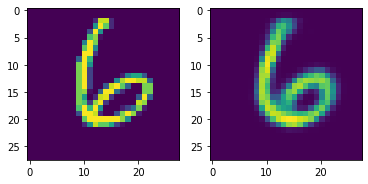

In [8]:
x = test_ft[108,:]
x_rec = model.predict(np.reshape(x,[1,-1]))

plt.subplot(1,2,1)
plt.imshow(np.reshape(x,[28,28]))
plt.subplot(1,2,2)
plt.imshow(np.reshape(x_rec,[28,28]))


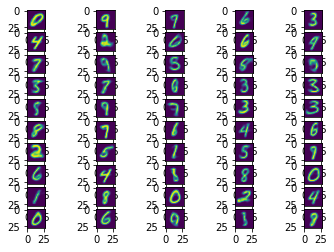

In [9]:
for i in range(10):
    for j in range(5):
        z = np.random.normal(0,1, size=[1,10])
        x_rec = model.predict_z(z)
        plt.subplot(10,5,i*5+j+1)
        plt.imshow(np.reshape(x_rec,[28,28]))

### 结果分析

之前实验一直不OK，最后发现Beta的值设置的太大了。
经验来看（不保证对），最终收敛的时候，kl项差不多在0.7左右可能会比较好。